In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
import time
import wandb
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import torch
from datetime import datetime
from collections import OrderedDict
from sklearn.decomposition import PCA
import flwr as fl
import random
from flwr.common import Metrics 
from time import gmtime, strftime
from flwr.server.strategy import FedAvg, FedAdagrad, FedProx
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

now = datetime.now() # current date and time
date_time = now.strftime("%d-%m-%Y_%H:%M:%S")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "centralized training_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

def data_loading_AZURE(data_paths, label_paths, batch_size, train_ratio=0.8, val_ratio=0.05, transfer_ratio= 0.4):
    trainloader = []
    valloader = []
    traindata_list = []
    trainlabel_list = []
    valdata_list = []
    vallabel_list = []
    testdata_list = []
    testlabels_list = []
    for i in range(len(data_paths)):
        # importing from paths
        data = torch.load(data_paths[i])
        labels = torch.load(label_paths[i])
        data = nn.functional.normalize(data, dim=1)
        # reshaping the dataset so  the channels will be the second dimension.
        data = data.permute(0, 2, 1)
        n_samples, n_channels, n_features = data.shape
        X_reshaped = data.reshape(n_samples, -1) 
        # Apply SMOTE
        smote = SMOTE(sampling_strategy='minority')
        data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
        # Reshape X_resampled back to 3D
        data_resampled = data_resampled.reshape(-1, n_channels, n_features)
        data_resampled = torch.tensor(data_resampled)
        labels_resampled = torch.tensor(labels_resampled)
        dataset = TensorDataset(data_resampled, labels_resampled)
        test_ratio = 1 - (train_ratio + val_ratio)
        print(test_ratio)
        test_size = int(test_ratio * len(dataset))
        print(test_size)
        transfer_size = int((len(dataset) - test_size)*transfer_ratio)
        train_size_t = int(train_ratio * transfer_size)
        val_size_t = transfer_size - train_size_t
        centralized_size = len(dataset) - (transfer_size + test_size)
        train_size = int(centralized_size * train_ratio)
        val_size = centralized_size - train_size

        train_dataset, val_dataset, test_dataset, train_dataset_transfer, val_dataset_transfer = random_split(dataset, [train_size, val_size, test_size, train_size_t, val_size_t])

        trainloader.append(DataLoader(train_dataset, batch_size=batch_size, shuffle=True))
        valloader.append(DataLoader(val_dataset, batch_size=batch_size, shuffle=True))

        traindata_list.append(train_dataset_transfer.dataset.tensors[0][train_dataset_transfer.indices])
        trainlabel_list.append(train_dataset_transfer.dataset.tensors[1][train_dataset_transfer.indices])
        valdata_list.append(val_dataset_transfer.dataset.tensors[0][val_dataset_transfer.indices])
        vallabel_list.append(val_dataset_transfer.dataset.tensors[1][val_dataset_transfer.indices])
        testdata_list.append(test_dataset.dataset.tensors[0][test_dataset.indices])
        testlabels_list.append(test_dataset.dataset.tensors[1][test_dataset.indices])

    traindata = torch.cat(traindata_list, dim=0)
    trainlabels = torch.cat(trainlabel_list, dim=0)
    valdata = torch.cat(valdata_list, dim=0)
    vallabels = torch.cat(vallabel_list, dim=0)
    testdata = torch.cat(testdata_list, dim=0)
    testlabels = torch.cat(testlabels_list, dim=0)
    
    # Create a DataLoader for the combined test data
    trainloader_transfer = DataLoader(TensorDataset(traindata, trainlabels), batch_size=batch_size, shuffle=False)
    valloader_transfer = DataLoader(TensorDataset(valdata, vallabels), batch_size=batch_size, shuffle=False)
    testloader = DataLoader(TensorDataset(testdata, testlabels), batch_size=batch_size, shuffle=False)
    
    return trainloader, valloader, testloader, trainloader_transfer, valloader_transfer

def data_loading_NASA(data_path, label_path, batch_size, train_ratio=0.8, val_ratio = 0.5):
    data = torch.load(data_path)
    labels = torch.load(label_path)
    data = nn.functional.normalize(data, dim=1)
    # reshaping the dataset so  the channels will be the second dimension.
    data = data.permute(0, 2, 1)
    print(data.size())

    def pca_reduction(data, n_components=4):
        data_reshaped = data.reshape(-1, data.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        
        data_reduced = pca.fit_transform(data_reshaped)

        # Reshape back to (samples, n_components, time_steps)
        data_reduced = data_reduced.reshape(data.shape[0], n_components, data.shape[2])

        return data_reduced
    print(data.dtype)
    data = pca_reduction(data, n_components=4)
    data =(torch.from_numpy(data)).float()
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    n_samples, n_channels, n_features = data.shape
    X_reshaped = data.reshape(n_samples, -1) 
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy='minority')
    data_resampled, labels_resampled = smote.fit_resample(X_reshaped, labels)
    print((labels_resampled==1).sum())
    # Reshape X_resampled back to 3D
    data_resampled = data_resampled.reshape(-1, n_channels, n_features)
    print(data_resampled.shape)
    data_resampled = torch.tensor(data_resampled)
    labels_resampled = torch.tensor(labels_resampled)
    dataset = TensorDataset(data_resampled, labels_resampled)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    val_size = int(val_ratio * test_size)
    test_size = test_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True), DataLoader(val_dataset, batch_size=batch_size, shuffle=True), DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


wandb: Currently logged in as: d-hadjikazemi (d-hadjikazemi-queen-mary-university-of-london). Use `wandb login --relogin` to force relogin
/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [3]:
# Define the CNN architecture
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(8)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = self.relu(self.conv1(x))
        # x = self.relu(self.conv2(x))
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [4]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n


In [5]:
def train(model, train_loaders,test_loader, config, epochs, name):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        wandb.log({f'{name} training accuracy': train_acc,
                   f'{name} validationaccuracy': test_acc})
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()
def test(model, test_loaders,  configuration):
    loss = nn.CrossEntropyLoss()
    test_accs = []
    optimizer = torch.optim.Adam(model.parameters(), lr=configuration['learning_rate'], weight_decay=configuration['decay'])
    test_acc = []
    l = 0.0
    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    for X, y in test_loaders:    
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        l = loss(logits, y).item()
        test_acc = evaluate_metric(model, test_loaders, correct)
        test_accs.append(test_acc)
        
        # wandb.log({"test_acc": test_acc})
        l /= len(test_loaders)
        end_time = time.perf_counter()
        # print('Testing accuracy: {test_accs[-1]}.')
        return l, test_acc

NASA = data_loading_NASA(data_path='NASA_data_50.pt', label_path= 'NASA_label_50.pt', batch_size= configuration['batch_size'])

torch.Size([848, 24, 50])
torch.float32
685
(1370, 4, 50)



Epoch 1/100
Epoch 1: Training accuracy: 51.0036506652832 Testing accuracy: 43.79561996459961.

Epoch 2/100
Epoch 2: Training accuracy: 51.733577728271484 Testing accuracy: 46.715328216552734.

Epoch 3/100
Epoch 3: Training accuracy: 52.73722457885742 Testing accuracy: 47.445255279541016.

Epoch 4/100
Epoch 4: Training accuracy: 63.22992706298828 Testing accuracy: 57.66423416137695.

Epoch 5/100
Epoch 5: Training accuracy: 60.94890594482422 Testing accuracy: 56.93430709838867.

Epoch 6/100
Epoch 6: Training accuracy: 59.39781188964844 Testing accuracy: 52.554744720458984.

Epoch 7/100
Epoch 7: Training accuracy: 64.32481384277344 Testing accuracy: 56.20438003540039.

Epoch 8/100
Epoch 8: Training accuracy: 63.3211669921875 Testing accuracy: 54.01459884643555.

Epoch 9/100
Epoch 9: Training accuracy: 59.8540153503418 Testing accuracy: 52.554744720458984.

Epoch 10/100
Epoch 10: Training accuracy: 68.6131362915039 Testing accuracy: 54.74452590942383.

Epoch 11/100
Epoch 11: Training accu

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


centralized training accuracy,▁▁▂▃▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
centralized validationaccuracy,▁▂▃▃▃▄▅▄▅▅▅▅▅▅▅▅▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇███████
centralized training accuracy,92.42701
centralized validationaccuracy,77.37226


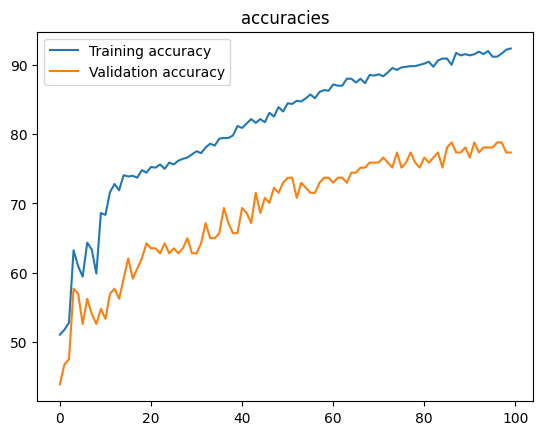

In [6]:
trainloader = NASA[0]
valloader = NASA[1]
testloader = NASA[2]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, valloader, configuration, configuration['epochs'], name= 'centralized')
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
loss, accuracy = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

## transfer learning

In [7]:
azure_data_paths = ['AZURE_data_1.pt', 'AZURE_data_2.pt','AZURE_data_3.pt','AZURE_data_4.pt']
azure_label_paths = ['AZURE_label_1.pt','AZURE_label_2.pt','AZURE_label_3.pt','AZURE_label_4.pt']
azure_train_loaders, azure_val_loaders, azure_test_loader, azure_train_loaders_transfer, azure_val_loaders_transfer = data_loading_AZURE(azure_data_paths, azure_label_paths, batch_size=configuration['batch_size_FL'])

0.1499999999999999
250
0.1499999999999999
233
0.1499999999999999
310
0.1499999999999999
253


In [8]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "transfer learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

/home/diba/miniconda3/envs/FTL/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display



Epoch 1/100
Epoch 1: Training accuracy: 52.05263137817383 Testing accuracy: 50.630252838134766.

Epoch 2/100
Epoch 2: Training accuracy: 64.63157653808594 Testing accuracy: 60.29411697387695.

Epoch 3/100
Epoch 3: Training accuracy: 68.10526275634766 Testing accuracy: 64.49579620361328.

Epoch 4/100
Epoch 4: Training accuracy: 70.9473648071289 Testing accuracy: 67.01680755615234.

Epoch 5/100
Epoch 5: Training accuracy: 72.68421173095703 Testing accuracy: 67.43697357177734.

Epoch 6/100
Epoch 6: Training accuracy: 73.84210205078125 Testing accuracy: 68.48739624023438.

Epoch 7/100
Epoch 7: Training accuracy: 74.84210205078125 Testing accuracy: 69.9579849243164.

Epoch 8/100
Epoch 8: Training accuracy: 75.47368621826172 Testing accuracy: 70.5882339477539.

Epoch 9/100
Epoch 9: Training accuracy: 76.7368392944336 Testing accuracy: 71.42857360839844.

Epoch 10/100
Epoch 10: Training accuracy: 77.42105102539062 Testing accuracy: 71.21849060058594.

Epoch 11/100
Epoch 11: Training accuracy

transfer training accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████████████
transfer validationaccuracy,▁▅▆▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇█▇█▇███▇▇███
transfer training accuracy,85.31579
transfer validationaccuracy,73.31933


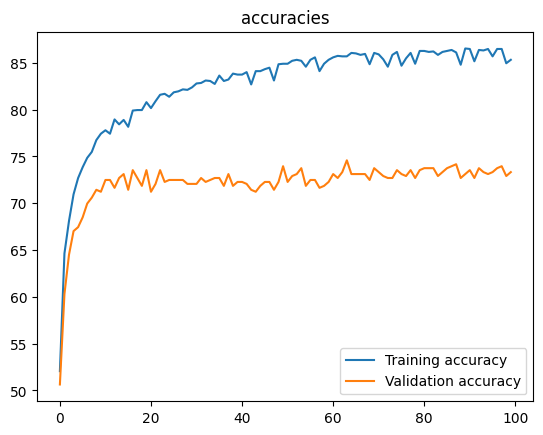

In [9]:
losses_transfer = []
accuracies_transfer = []
for epoch in range(1):
    train(net, azure_train_loaders_transfer, azure_val_loaders_transfer, configuration, configuration['epochs'], name= 'transfer')
    loss, accuracy = test(net, azure_val_loaders_transfer, configuration)
    losses_transfer.append(loss)
    accuracies_transfer.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
# plt.plot(accuracies)
losses_transfer, accuracy_transfer = test(net, testloader, configuration=configuration)

print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")
wandb.finish()

trainloader = train_loaders[1]
valloader = val_loaders[1]
testloader = test_loaders[1]
net = Neural_Network().to(device)
losses = []
accuracies = []
for epoch in range(1):
    train(net, trainloader, testloader, configuration, configuration['epochs'])
    loss, accuracy = test(net, valloader, configuration)
    losses.append(loss)
    accuracies.append(int(accuracy))
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
<!-- # plt.plot(accuracies) -->
loss, accuracy = test(net, testloader, configuration=configuration)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

## Federated Learning

In [10]:
wandb.init(
    # set the wandb project where this run will be logged
    project="FTL unified",
    name= "federated learning phase_{}".format(date_time),
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "epochs": 100,
    "batch_size": 64,
    "decay":0,
    'dropout': 0.001,
    "learning_rate_FL": 0.0001,
    "batch_size_FL": 64,
    "decay_FL": 1e-5,
    'num_rounds_FL': 50, 
    'epochs_FL': 100,
    'dropout_FL': 0.001
    }
)

configuration  = dict(wandb.config)

In [11]:
# Define the CNN architecture
class Neural_Network_FL(nn.Module):
    def __init__(self):
        super(Neural_Network_FL, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=2, padding=0, stride=1)
        # the size of the out channels x number  of nodes 
        self.fc1 = nn.Linear(328, 200)
        self.fc2 = nn.Linear(200, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(configuration['dropout'])
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x - self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

In [12]:
def train_FL(model, train_loaders,test_loader, config, epochs):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['decay'])
    losses = [] # Stores the loss for each training batch
    train_accs = [] # Stores the training accuracy after each epoch
    test_accs = []
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        total, epoch_loss = 0, 0.0
        model.train() # This is necessary because batch normalization behaves differently between training and evaluation
        
        for X, y in train_loaders:
            X, y = X.to(device), y.to(device) # Moves data to `device`
            logits = model(X) # Computes the logits for the batch of images `X`
            l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
            optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
            l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

            optimizer.step() # Updates the model parameters based on the gradients stored inside them
            epoch_loss += l
            
        model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
        train_acc = evaluate_metric(model, train_loaders, correct)
        train_accs.append(train_acc)
        test_acc = evaluate_metric(model, test_loader, correct)
        test_accs.append(test_acc)
        print(f'Epoch {epoch+1}: Training accuracy: {train_accs[-1]} Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.
    plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
    plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Validation accuracy')
    plt.title('accuracies')
    plt.legend()


In [13]:
def get_parameters(model):
    # Return model parameters as a list of NumPy ndarrays, excluding parameters of BN layers when using FedBN
    return [val.cpu().numpy() for name, val in model.state_dict().items() if ('bn1' not in name and 'bn2' not in name)]

def set_parameters(model, parameters):
    # Set model parameters from a list of NumPy ndarrays
    keys = [k for k in model.state_dict().keys() if 'bn' not in k]
    params_dict = zip(keys, parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=False)

net_FL = Neural_Network_FL().to(device)
parameters_centralized = get_parameters(net)
set_parameters(net_FL, parameters_centralized)

In [14]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader, configuration):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train_FL(self.net, self.trainloader,self.valloader,configuration, configuration['epochs_FL'])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader, configuration)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    

def client_fn(cid) -> FlowerClient:
    net = Neural_Network().to(device)
    trainloader = azure_train_loaders[int(cid)]
    valloader = azure_val_loaders[int(cid)]
    return FlowerClient(net_FL, trainloader, valloader, configuration).to_client()


In [15]:
# client will be allocated 1x CPU and 0x GPUs
if device.type == 'cuda':
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.
    
# The `evaluate` function will be called by Flower after every round
fl_acc = []
def evaluate(server_round,parameters,config,):
    testloader = azure_test_loader
    set_parameters(net_FL, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net_FL, testloader, configuration)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    fl_acc.append(accuracy)
    metrics = {'FL loss': loss,
               "FL accuracy": accuracy}
    wandb.log(metrics)
    return loss, {"accuracy": accuracy}

def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}
params = get_parameters(net_FL)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1,
    fraction_evaluate=0.5,
    min_fit_clients=2,
    min_evaluate_clients=1,
    min_available_clients=1,
    evaluate_fn=evaluate,
    initial_parameters= ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn=weighted_average # <-- pass the metric aggregation function
)
# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=4,
    config=fl.server.ServerConfig(num_rounds=configuration['num_rounds_FL']),
    strategy=strategy,
    client_resources=client_resources,
)

Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
2024-08-12 15:52:34,001	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 58118660505.0, 'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 2.0, 'CPU': 32.0, 'node:192.168.1.146': 1.0, 'memory': 125610207847.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :

Server-side evaluation loss 0.04860447785433601 / accuracy 49.426387786865234
(ClientAppActor pid=2312932) 
(ClientAppActor pid=2312932) Epoch 1/100
(ClientAppActor pid=2312932) Epoch 1: Training accuracy: 51.42180252075195 Testing accuracy: 48.58490753173828.
(ClientAppActor pid=2312932) Epoch 2: Training accuracy: 51.42180252075195 Testing accuracy: 48.58490753173828.
(ClientAppActor pid=2312932) Epoch 3: Training accuracy: 51.42180252075195 Testing accuracy: 48.58490753173828.
(ClientAppActor pid=2312932) Epoch 4: Training accuracy: 51.42180252075195 Testing accuracy: 48.58490753173828.
(ClientAppActor pid=2312932) Epoch 5: Training accuracy: 51.42180252075195 Testing accuracy: 48.58490753173828.
(ClientAppActor pid=2312932) Epoch 6: Training accuracy: 51.42180252075195 Testing accuracy: 48.58490753173828.
(ClientAppActor pid=2312932) Epoch 7: Training accuracy: 51.42180252075195 Testing accuracy: 48.58490753173828.
(ClientAppActor pid=2312932) Epoch 8: Training accuracy: 51.4218025

INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 0.040785838575924147, {'accuracy': tensor(49.4264, device='cuda:0')}, 4.549421048955992)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.040785838575924147 / accuracy 49.426387786865234
(ClientAppActor pid=2312932)  [repeated 615x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=2312932) Epoch 100/100 [repeated 615x across cluster]
(ClientAppActor pid=2312932) Epoch 13: Training accuracy: 50.869564056396484 Testing accuracy: 52.02312088012695. [repeated 636x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 0.04077709773007561, {'accuracy': tensor(49.4264, device='cuda:0')}, 7.747532713925466)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04077709773007561 / accuracy 49.426387786865234


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.040745272355921125, {'accuracy': tensor(49.2352, device='cuda:0')}, 10.943483177921735)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.040745272355921125 / accuracy 49.23517990112305
(ClientAppActor pid=2312932)  [repeated 635x across cluster]
(ClientAppActor pid=2312932) Epoch 26/100 [repeated 635x across cluster]
(ClientAppActor pid=2312932) Epoch 37: Training accuracy: 51.42180252075195 Testing accuracy: 48.58490753173828. [repeated 632x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.04051454978830674, {'accuracy': tensor(63.7667, device='cuda:0')}, 14.090957740903832)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.04051454978830674 / accuracy 63.76673126220703
(ClientAppActor pid=2312932)  [repeated 675x across cluster]
(ClientAppActor pid=2312932) Epoch 59/100 [repeated 675x across cluster]
(ClientAppActor pid=2312932) Epoch 70: Training accuracy: 64.4549789428711 Testing accuracy: 63.20754623413086. [repeated 673x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.03957390434601728, {'accuracy': tensor(72.6577, device='cuda:0')}, 17.256644191918895)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03957390434601728 / accuracy 72.65774536132812


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.03767301405177397, {'accuracy': tensor(74.2830, device='cuda:0')}, 20.394956572912633)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03767301405177397 / accuracy 74.2829818725586
(ClientAppActor pid=2312932)  [repeated 610x across cluster]
(ClientAppActor pid=2312932) Epoch 64/100 [repeated 610x across cluster]
(ClientAppActor pid=2312932) Epoch 74: Training accuracy: 74.05213165283203 Testing accuracy: 72.16981506347656. [repeated 611x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 0.03556669810239006, {'accuracy': tensor(74.5698, device='cuda:0')}, 23.576474718982354)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03556669810239006 / accuracy 74.56978607177734


INFO :      aggregate_fit: received 4 results and 0 failures


(ClientAppActor pid=2312932)  [repeated 653x across cluster]
(ClientAppActor pid=2312932) Epoch 89/100 [repeated 653x across cluster]


INFO :      fit progress: (8, 0.033864406978382784, {'accuracy': tensor(74.8566, device='cuda:0')}, 26.75273396994453)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=2312932) Epoch 100: Training accuracy: 74.28910064697266 Testing accuracy: 73.58490753173828. [repeated 640x across cluster]
Server-side evaluation loss 0.033864406978382784 / accuracy 74.85659790039062


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.032457846052506394, {'accuracy': tensor(73.9962, device='cuda:0')}, 29.866551181999967)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.032457846052506394 / accuracy 73.99617767333984
(ClientAppActor pid=2312932)  [repeated 641x across cluster]
(ClientAppActor pid=2312932) Epoch 17/100 [repeated 641x across cluster]
(ClientAppActor pid=2312932) Epoch 29: Training accuracy: 73.93364715576172 Testing accuracy: 76.41509246826172. [repeated 657x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.03220673869637882, {'accuracy': tensor(75.1434, device='cuda:0')}, 33.08353783690836)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03220673869637882 / accuracy 75.14340209960938


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.031277642530553484, {'accuracy': tensor(73.9006, device='cuda:0')}, 36.33689658297226)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031277642530553484 / accuracy 73.90057373046875
(ClientAppActor pid=2312932)  [repeated 602x across cluster]
(ClientAppActor pid=2312932) Epoch 19/100 [repeated 602x across cluster]
(ClientAppActor pid=2312932) Epoch 33: Training accuracy: 76.52173614501953 Testing accuracy: 69.94219970703125. [repeated 604x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.03146512017530553, {'accuracy': tensor(74.9522, device='cuda:0')}, 39.50001303991303)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03146512017530553 / accuracy 74.95220184326172
(ClientAppActor pid=2312932)  [repeated 640x across cluster]
(ClientAppActor pid=2312932) Epoch 57/100 [repeated 640x across cluster]
(ClientAppActor pid=2312932) Epoch 72: Training accuracy: 75.66719055175781 Testing accuracy: 75.0. [repeated 640x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.031283557415008545, {'accuracy': tensor(74.9522, device='cuda:0')}, 42.792353190947324)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031283557415008545 / accuracy 74.95220184326172


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.0313113016240737, {'accuracy': tensor(74.8566, device='cuda:0')}, 45.89597038796637)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0313113016240737 / accuracy 74.85659790039062
(ClientAppActor pid=2312932)  [repeated 620x across cluster]
(ClientAppActor pid=2312932) Epoch 57/100 [repeated 620x across cluster]
(ClientAppActor pid=2312932) Epoch 72: Training accuracy: 74.41130065917969 Testing accuracy: 76.875. [repeated 616x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.03115560727960923, {'accuracy': tensor(75.1434, device='cuda:0')}, 49.16860096191522)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03115560727960923 / accuracy 75.14340209960938
(ClientAppActor pid=2312932)  [repeated 656x across cluster]
(ClientAppActor pid=2312932) Epoch 69/100 [repeated 656x across cluster]
(ClientAppActor pid=2312932) Epoch 80: Training accuracy: 74.76303100585938 Testing accuracy: 76.88679504394531. [repeated 657x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (16, 0.03132843620636884, {'accuracy': tensor(75.7170, device='cuda:0')}, 52.33134141692426)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03132843620636884 / accuracy 75.7170181274414


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (17, 0.030725598335266113, {'accuracy': tensor(74.6654, device='cuda:0')}, 55.71127033489756)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030725598335266113 / accuracy 74.66539001464844
(ClientAppActor pid=2312932)  [repeated 605x across cluster]
(ClientAppActor pid=2312932) Epoch 80/100 [repeated 605x across cluster]
(ClientAppActor pid=2312932) Epoch 93: Training accuracy: 78.56094360351562 Testing accuracy: 77.19298553466797. [repeated 607x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (18, 0.03082538001677569, {'accuracy': tensor(75.1434, device='cuda:0')}, 58.9253935739398)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03082538001677569 / accuracy 75.14340209960938
(ClientAppActor pid=2312935)  [repeated 626x across cluster]
(ClientAppActor pid=2312935) Epoch 79/100 [repeated 626x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures


(ClientAppActor pid=2312935) Epoch 89: Training accuracy: 77.48815155029297 Testing accuracy: 76.88679504394531. [repeated 608x across cluster]


INFO :      fit progress: (19, 0.030914303134469426, {'accuracy': tensor(75.9082, device='cuda:0')}, 62.26935000496451)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030914303134469426 / accuracy 75.90821838378906


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (20, 0.030831684084499583, {'accuracy': tensor(75.8126, device='cuda:0')}, 65.403779500979)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030831684084499583 / accuracy 75.8126220703125
(ClientAppActor pid=2312932)  [repeated 600x across cluster]
(ClientAppActor pid=2312932) Epoch 3/100 [repeated 600x across cluster]
(ClientAppActor pid=2312932) Epoch 18: Training accuracy: 77.23704528808594 Testing accuracy: 75.625. [repeated 615x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (21, 0.030870451646692613, {'accuracy': tensor(75.9082, device='cuda:0')}, 68.755100623006)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030870451646692613 / accuracy 75.90821838378906


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (22, 0.03086607947069056, {'accuracy': tensor(75.8126, device='cuda:0')}, 72.03141822398175)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


(ClientAppActor pid=2312935)  [repeated 620x across cluster]
(ClientAppActor pid=2312935) Epoch 99/100 [repeated 620x across cluster]
Server-side evaluation loss 0.03086607947069056 / accuracy 75.8126220703125
(ClientAppActor pid=2312932) Epoch 5: Training accuracy: 77.25118255615234 Testing accuracy: 76.88679504394531. [repeated 601x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (23, 0.030715710976544547, {'accuracy': tensor(75.1434, device='cuda:0')}, 75.29988196899649)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030715710976544547 / accuracy 75.14340209960938
(ClientAppActor pid=2312932)  [repeated 622x across cluster]
(ClientAppActor pid=2312932) Epoch 30/100 [repeated 622x across cluster]
(ClientAppActor pid=2312932) Epoch 44: Training accuracy: 77.82608795166016 Testing accuracy: 65.89595031738281. [repeated 639x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (24, 0.030830733916338754, {'accuracy': tensor(76.0994, device='cuda:0')}, 78.58232224499807)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030830733916338754 / accuracy 76.09942626953125


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (25, 0.030710974160362694, {'accuracy': tensor(74.4742, device='cuda:0')}, 81.6672738409834)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030710974160362694 / accuracy 74.47418975830078
(ClientAppActor pid=2312932)  [repeated 632x across cluster]
(ClientAppActor pid=2312932) Epoch 30/100 [repeated 632x across cluster]
(ClientAppActor pid=2312932) Epoch 44: Training accuracy: 77.68115997314453 Testing accuracy: 68.78612518310547. [repeated 637x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (26, 0.030815594336565805, {'accuracy': tensor(75.9082, device='cuda:0')}, 85.08870379789732)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030815594336565805 / accuracy 75.90821838378906
(ClientAppActor pid=2312932)  [repeated 623x across cluster]
(ClientAppActor pid=2312932) Epoch 27/100 [repeated 623x across cluster]
(ClientAppActor pid=2312932) Epoch 41: Training accuracy: 77.82608795166016 Testing accuracy: 68.20809173583984. [repeated 622x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (27, 0.030919930514167335, {'accuracy': tensor(76.7686, device='cuda:0')}, 88.29450815892778)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030919930514167335 / accuracy 76.76864624023438


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (28, 0.030800889520084158, {'accuracy': tensor(73.7094, device='cuda:0')}, 91.50883560196962)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.030800889520084158 / accuracy 73.70936584472656
(ClientAppActor pid=2312932)  [repeated 616x across cluster]
(ClientAppActor pid=2312932) Epoch 45/100 [repeated 616x across cluster]
(ClientAppActor pid=2312932) Epoch 56: Training accuracy: 78.43601989746094 Testing accuracy: 76.88679504394531. [repeated 613x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (29, 0.03082248042611515, {'accuracy': tensor(74.6654, device='cuda:0')}, 94.69647710793652)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03082248042611515 / accuracy 74.66539001464844
(ClientAppActor pid=2312932)  [repeated 673x across cluster]
(ClientAppActor pid=2312932) Epoch 100/100 [repeated 673x across cluster]
(ClientAppActor pid=2312935) Epoch 81: Training accuracy: 77.60663604736328 Testing accuracy: 76.41509246826172. [repeated 665x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (30, 0.0308611603344188, {'accuracy': tensor(73.5182, device='cuda:0')}, 97.98274293891154)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0308611603344188 / accuracy 73.5181655883789


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (31, 0.03090038720299216, {'accuracy': tensor(75.8126, device='cuda:0')}, 101.17885131796356)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03090038720299216 / accuracy 75.8126220703125
(ClientAppActor pid=2312932)  [repeated 582x across cluster]
(ClientAppActor pid=2312932) Epoch 85/100 [repeated 582x across cluster]
(ClientAppActor pid=2312932) Epoch 99: Training accuracy: 79.88252258300781 Testing accuracy: 80.70175170898438. [repeated 591x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (32, 0.03097238961388083, {'accuracy': tensor(76.1950, device='cuda:0')}, 104.50565609789919)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03097238961388083 / accuracy 76.19503021240234
(ClientAppActor pid=2312935)  [repeated 632x across cluster]
(ClientAppActor pid=2312935) Epoch 79/100 [repeated 632x across cluster]
(ClientAppActor pid=2312935) Epoch 90: Training accuracy: 77.7251205444336 Testing accuracy: 76.41509246826172. [repeated 618x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (33, 0.031014414394603056, {'accuracy': tensor(76.1950, device='cuda:0')}, 107.9441150429193)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031014414394603056 / accuracy 76.19503021240234


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (34, 0.03101634278016932, {'accuracy': tensor(76.2906, device='cuda:0')}, 111.27878424199298)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03101634278016932 / accuracy 76.29063415527344
(ClientAppActor pid=2312932)  [repeated 598x across cluster]
(ClientAppActor pid=2312932) Epoch 94/100 [repeated 598x across cluster]
(ClientAppActor pid=2312932) Epoch 6: Training accuracy: 77.864990234375 Testing accuracy: 74.375. [repeated 613x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (35, 0.03106118300381829, {'accuracy': tensor(76.0038, device='cuda:0')}, 114.63965466700029)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03106118300381829 / accuracy 76.00382232666016


INFO :      aggregate_fit: received 4 results and 0 failures


(ClientAppActor pid=2312935)  [repeated 614x across cluster]
(ClientAppActor pid=2312935) Epoch 91/100 [repeated 614x across cluster]


INFO :      fit progress: (36, 0.03111394713906681, {'accuracy': tensor(76.2906, device='cuda:0')}, 117.91081064101309)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03111394713906681 / accuracy 76.29063415527344
(ClientAppActor pid=2312935) Epoch 100: Training accuracy: 77.36966705322266 Testing accuracy: 74.05660247802734. [repeated 597x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (37, 0.03130494847017176, {'accuracy': tensor(77.0555, device='cuda:0')}, 121.02785202290397)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03130494847017176 / accuracy 77.05545043945312
(ClientAppActor pid=2312932)  [repeated 631x across cluster]
(ClientAppActor pid=2312932) Epoch 100/100 [repeated 631x across cluster]
(ClientAppActor pid=2312932) Epoch 12: Training accuracy: 79.4419937133789 Testing accuracy: 76.60818481445312. [repeated 646x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (38, 0.031313710352953744, {'accuracy': tensor(77.0555, device='cuda:0')}, 124.30345883395057)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031313710352953744 / accuracy 77.05545043945312


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (39, 0.031233026700861314, {'accuracy': tensor(76.6730, device='cuda:0')}, 127.55012674001046)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031233026700861314 / accuracy 76.67304229736328
(ClientAppActor pid=2312932)  [repeated 615x across cluster]
(ClientAppActor pid=2312932) Epoch 23/100 [repeated 615x across cluster]
(ClientAppActor pid=2312932) Epoch 39: Training accuracy: 78.33595275878906 Testing accuracy: 73.125. [repeated 620x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (40, 0.03139588061500998, {'accuracy': tensor(76.7686, device='cuda:0')}, 130.68243239994626)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03139588061500998 / accuracy 76.76864624023438
(ClientAppActor pid=2312932)  [repeated 636x across cluster]
(ClientAppActor pid=2312932) Epoch 21/100 [repeated 636x across cluster]
(ClientAppActor pid=2312932) Epoch 35: Training accuracy: 76.3768081665039 Testing accuracy: 71.67630004882812. [repeated 635x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (41, 0.031145474489997414, {'accuracy': tensor(75.8126, device='cuda:0')}, 134.01666947791819)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031145474489997414 / accuracy 75.8126220703125


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (42, 0.03145870741675882, {'accuracy': tensor(76.9598, device='cuda:0')}, 137.3186704859836)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03145870741675882 / accuracy 76.95984649658203
(ClientAppActor pid=2312932)  [repeated 609x across cluster]
(ClientAppActor pid=2312932) Epoch 51/100 [repeated 609x across cluster]
(ClientAppActor pid=2312932) Epoch 67: Training accuracy: 77.7080078125 Testing accuracy: 74.375. [repeated 608x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (43, 0.03129399874631096, {'accuracy': tensor(76.3862, device='cuda:0')}, 140.6296432929812)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03129399874631096 / accuracy 76.38623046875
(ClientAppActor pid=2312932)  [repeated 631x across cluster]
(ClientAppActor pid=2312932) Epoch 59/100 [repeated 631x across cluster]
(ClientAppActor pid=2312932) Epoch 70: Training accuracy: 76.540283203125 Testing accuracy: 73.58490753173828. [repeated 629x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (44, 0.03129460881738102, {'accuracy': tensor(76.0994, device='cuda:0')}, 143.83642419299576)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03129460881738102 / accuracy 76.09942626953125


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (45, 0.031541361528284406, {'accuracy': tensor(77.0555, device='cuda:0')}, 147.18570913397707)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.031541361528284406 / accuracy 77.05545043945312
(ClientAppActor pid=2312932)  [repeated 621x across cluster]
(ClientAppActor pid=2312932) Epoch 75/100 [repeated 621x across cluster]
(ClientAppActor pid=2312932) Epoch 91: Training accuracy: 79.59183502197266 Testing accuracy: 73.75. [repeated 625x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (46, 0.0313686868723701, {'accuracy': tensor(76.2906, device='cuda:0')}, 150.41337847500108)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.0313686868723701 / accuracy 76.29063415527344
(ClientAppActor pid=2312932)  [repeated 645x across cluster]
(ClientAppActor pid=2312932) Epoch 80/100 [repeated 645x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (47, 0.03253695193459006, {'accuracy': tensor(76.2906, device='cuda:0')}, 153.68508712400217)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)


(ClientAppActor pid=2312932) Epoch 90: Training accuracy: 74.88151550292969 Testing accuracy: 75.94339752197266. [repeated 627x across cluster]
Server-side evaluation loss 0.03253695193459006 / accuracy 76.29063415527344


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (48, 0.03165783952264225, {'accuracy': tensor(77.2467, device='cuda:0')}, 157.00210098491516)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03165783952264225 / accuracy 77.24665069580078
(ClientAppActor pid=2312932)  [repeated 603x across cluster]
(ClientAppActor pid=2312932) Epoch 100/100 [repeated 603x across cluster]
(ClientAppActor pid=2312932) Epoch 8: Training accuracy: 76.42179870605469 Testing accuracy: 76.88679504394531. [repeated 614x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (49, 0.03138756401398603, {'accuracy': tensor(75.2390, device='cuda:0')}, 160.13134335901123)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 4 clients (out of 4)


Server-side evaluation loss 0.03138756401398603 / accuracy 75.23900604248047


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (50, 0.031642412438112145, {'accuracy': tensor(77.2467, device='cuda:0')}, 163.46506122895516)
INFO :      configure_evaluate: strategy sampled 2 clients (out of 4)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 rounds in 163.50s


(ClientAppActor pid=2312935)  [repeated 612x across cluster]
(ClientAppActor pid=2312935) Epoch 94/100 [repeated 612x across cluster]
Server-side evaluation loss 0.031642412438112145 / accuracy 77.24665069580078


INFO :      History (loss, distributed):
INFO :      	('\tround 1: 0.23124159375826517\n'
INFO :      	 '\tround 2: 0.19788219247545516\n'
INFO :      	 '\tround 3: 0.2308987577756246\n'
INFO :      	 '\tround 4: 0.22997260093688965\n'
INFO :      	 '\tround 5: 0.2245245079199473\n'
INFO :      	 '\tround 6: 0.2114583949247996\n'
INFO :      	 '\tround 7: 0.17636303390775407\n'
INFO :      	 '\tround 8: 0.16462179592677526\n'
INFO :      	 '\tround 9: 0.17472559213638306\n'
INFO :      	 '\tround 10: 0.16427961417606898\n'
INFO :      	 '\tround 11: 0.20256271958351135\n'
INFO :      	 '\tround 12: 0.18092875679334006\n'
INFO :      	 '\tround 13: 0.16197559663227626\n'
INFO :      	 '\tround 14: 0.14923231090818131\n'
INFO :      	 '\tround 15: 0.18627438942591348\n'
INFO :      	 '\tround 16: 0.15423194851194108\n'
INFO :      	 '\tround 17: 0.17050009114401682\n'
INFO :      	 '\tround 18: 0.1690016140540441\n'
INFO :      	 '\tround 19: 0.15878157104764665\n'
INFO :      	 '\tround

(ClientAppActor pid=2312935) Epoch 100: Training accuracy: 78.90995025634766 Testing accuracy: 75.94339752197266. [repeated 596x across cluster]


Text(0.5, 0, 'Rounds')

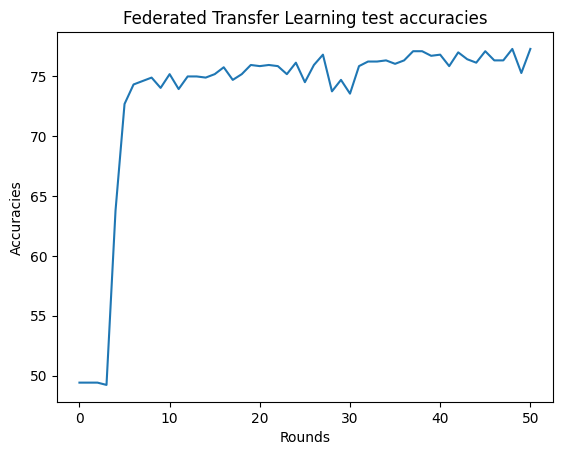

In [16]:
fl_acc
f = []
for i in fl_acc:
    f.append(float(i))
plt.plot(f)
plt.title('Federated Transfer Learning test accuracies')
plt.ylabel('Accuracies')
plt.xlabel('Rounds')